In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

In [ ]:
import os
%cd E:\Summer2021Research\lvl5_sample

E:\Summer2021Research\lvl5_sample


In [ ]:
# install dependencies:
!pip install pyyaml==5.1

In [ ]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html --user
exit(0)

In [ ]:
# Non-colab installation
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

ERROR: Invalid requirement: "'git+https://github.com/facebookresearch/detectron2.git'"


In [ ]:
import torch, torchvision
from torchvision import transforms
print(torch.__version__, torchvision.__version__,  torch.cuda.is_available())
assert torch.__version__.startswith("1.8")

# import some common libraries
import numpy as np
from PIL import Image
import os, json, glob, cv2, random, pickle
from pycocotools.coco import COCO

#%cd /gdrive/My Drive/

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# %cd /gdrive/My Drive/github/Chicken-Behavior-Tracker/Won
# from detectron2_wrapper import register_datasets, evaluate, check_annotations, get_detector

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
# another equivalent way to evaluate the model is to use `trainer.test`

1.8.1+cu111 0.9.1+cu111 True


In [ ]:
from os import listdir
from os.path import isfile, join

def ResizeFolder(path, size):

  onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

  for file in onlyfiles:

    img_path = join(path, file)
    img = Image.open(img_path)

    img = img.resize(size)

    img.save(img_path)

In [ ]:
def coco2detectron(root, annFile, classes):
    """ for each image, you check the number of ground truth and predicted objects from our model, then determine if the prediction finds at least one object of interest
    
    returns: 
        - dataset_dicts
        
    params:
        - root: 
        - annFile: 
        - classes:
    """
    thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19, 22: 20, 23: 21, 24: 22, 25: 23, 27: 24, 28: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39, 46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 52: 46, 53: 47, 54: 48, 55: 49, 56: 50, 57: 51, 58: 52, 59: 53, 60: 54, 61: 55, 62: 56, 63: 57, 64: 58, 65: 59, 67: 60, 70: 61, 72: 62, 73: 63, 74: 64, 75: 65, 76: 66, 77: 67, 78: 68, 79: 69, 80: 70, 81: 71, 82: 72, 84: 73, 85: 74, 86: 75, 87: 76, 88: 77, 89: 78, 90: 79}
    dataset_dicts = [] # list[dict]

    coco = COCO(annFile) # load entire coco annotation file
    ids = sorted(coco.getImgIds(catIds=coco.getCatIds(catNms=classes))) # get list of image ids
    print("number of images in {} = {}".format(classes, len(ids)))

    for img_id in ids:
        ann_ids = coco.getAnnIds(imgIds=img_id) # load annotation ids related to that image id
        coco_annotation = coco.loadAnns(ann_ids) # load annotation labels in that image id from annotation ids
        path = coco.loadImgs(img_id)[0]['file_name'] # load image annotation related to that image id

        record = {} # dict for single image

        record["file_name"] = os.path.join(root, path) # must be full path to where the image is
        height, width = cv2.imread(record['file_name']).shape[:2]

        record["image_id"] = img_id # must be unique across #s
        record["height"] = height
        record["width"] = width

        objs = [] # list[dict]: for each object in the image

        for i in range(len(coco_annotation)):
            xmin = np.round(coco_annotation[i]['bbox'][0], 2)
            ymin = np.round(coco_annotation[i]['bbox'][1], 2)
            xmax = np.round(xmin + coco_annotation[i]['bbox'][2], 2)
            ymax = np.round(ymin + coco_annotation[i]['bbox'][3], 2)

            obj = {
            "bbox": [xmin, ymin, xmax, ymax],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": thing_dataset_id_to_contiguous_id[coco_annotation[i]['category_id']]            
            }
            objs.append(obj)

        record["annotations"] = objs
        
        dataset_dicts.append(record) # list[dict]

    return dataset_dicts

In [ ]:
class SubCocoDetection(torch.utils.data.Dataset):
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
    root (string): Root directory where images are downloaded to.
    annFile (string): Path to json annotation file.
    transform (callable, optional): A function/transform that  takes in an PIL image and returns a transformed version. E.g, ``transforms.ToTensor``
    target_transform (callable, optional): A function/transform that takes in the target and transforms it.
    transforms (callable, optional): A function/transform that takes input sample and its target as entry and returns a transformed version.
    """

    def __init__(self, root, annFile, classes, transform=None, target_transform=None, transforms=None):
        # super(CocoDetection, self).__init__(root, transforms, transform, target_transform)
        self.root = root
        self.coco = COCO(annFile) # load entire coco annotation file
        self.transforms = transforms
        self.ids = sorted(self.coco.getImgIds(catIds=self.coco.getCatIds(catNms=classes))) # get list of image ids (indices?) 
        print("number of images in {} = {}".format(classes, len(self.ids)))

    def __getitem__(self, index):
        """
        Args:
            index (int): index

        Returns:
            img, target (tuple): target is the object returned by ``coco.loadAnns``.
        """

        thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19, 22: 20, 23: 21, 24: 22, 25: 23, 27: 24, 28: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39, 46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 52: 46, 53: 47, 54: 48, 55: 49, 56: 50, 57: 51, 58: 52, 59: 53, 60: 54, 61: 55, 62: 56, 63: 57, 64: 58, 65: 59, 67: 60, 70: 61, 72: 62, 73: 63, 74: 64, 75: 65, 76: 66, 77: 67, 78: 68, 79: 69, 80: 70, 81: 71, 82: 72, 84: 73, 85: 74, 86: 75, 87: 76, 88: 77, 89: 78, 90: 79}
        coco = self.coco
        img_id = self.ids[index] # get one image id according to the index
        ann_ids = coco.getAnnIds(imgIds=img_id) # load annotation ids related to that image id
        coco_annotation = coco.loadAnns(ann_ids) # load annotation labels in that image id from annotation ids
      
        path = coco.loadImgs(img_id)[0]['file_name'] # load image annotation related to that image id
        img = Image.open(os.path.join(self.root, path)).convert('RGB') # open the PIL image
        
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []

        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(thing_dataset_id_to_contiguous_id[coco_annotation[i]['category_id']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([img_id])    
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        target["iscrowd"] = iscrowd

        # preprocess image if wanted
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, target

    def __len__(self):
        return len(self.ids)


def get_transform():
    custom_transforms = []
    custom_transforms.append(transforms.Resize((640, 480)))
    return transforms.Compose(custom_transforms)


def filter_pos_pred(dataset, model, cls, cfg, max_img):
    """ to completely isolate the effect of the perturbation, we have to only use the images that the detector results in correct prediction
    
    returns: 
        - train_data: list[tuple], images that have at least one correct prediction of our target class

    params:
        - dataset: the dataset that we want to filter out
        - model: the object detector we want to test on
        - cls: the target class that we are interested in
        - cfg: config file that contains class category strings for COCO2017 train
        - max_img: max number of images that we want to keep as training data
    """

    # split into train and val data
    train_data = []
    gt_total_count = 0
    pred_total_count = 0
    img_num = 0

    for i in range(len(dataset)):
        is_correct, gt_count, pred_count = is_pos_pred(dataset[i], model, cls, cfg) # dataset[i]=Pil Object
        
        if is_correct is True:
            train_data.append(dataset[i])
            img_num += 1
            gt_total_count += gt_count
            pred_total_count += pred_count

            # finish if collected images exceed the desired number of training examples
            if img_num >= max_img:
                break
            
    print('ground truth # of classes for filtered images: {}, predicted # of classes for filtered images: {}'.format(gt_total_count, pred_total_count))
    print('number of filtered images: {}'.format(len(train_data)))
    return train_data


def is_pos_pred(data, model, cls, cfg):
    """ for each image, you check the number of ground truth and predicted objects from our model, then determine if the prediction finds at least one object of interest
    
    returns: 
        - is_pos_pred: boolean, the prediction finds at least one correct object detection of interest
        - gt_count: int, the number of ground truth objects of our interest in the image
        - pred_count: int, the number of predicted objects of our interest in the image

    params:
        - data:
        - model: the object detector we want to test on
        - cls: the target class that we are interested in
        - cfg: config file that contains class category strings for COCO2017 train
    """
       
    # convert image PIL to torch tensor 
    img, target = data
    
    pred_count = 0
    gt_count = np.sum((target["labels"].numpy() == cls)) # How many of the objects in the image are of the specified class
    is_pos_pred = False
    
    img = np.array(img) # convert image PIL to numpy
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #cv2_imshow(img)
    img_t = torch.from_numpy(img).float() # convert numpy to torch tensor
    img_t = img_t.permute(2, 0, 1) # (H, W, C) to (C, H, W)
    
    # add universal adversarial perturbation to clean image
    img_dict = [dict(image=img_t)] # for detectron2 format

    # run detection on the model and get the confidence scores of the detections
    outputs = model(img_dict)[0]
    outputs = outputs['instances']

    outputs.pred_boxes.tensor = torch.tensor(outputs.pred_boxes.tensor, requires_grad=False)

    # for each instance prediction, 
    for idx, pred_cls in enumerate(outputs.pred_classes):

        # check that predicted class is the target class 
        if pred_cls.item() == cls:

            # compare it with all ground truth boxes of the target class
            for i, gt_labels in enumerate(target["labels"]):

                # if the gt box is the target class, compute their iou to see if it's true positive
                if gt_labels.item() == pred_cls:
                    gt_box = target['boxes'][i]

                    if bb_intersection_over_union(outputs.pred_boxes.tensor[idx].cpu().numpy(), gt_box.numpy()) > 0.5:
                        is_pos_pred = True
                        pred_count += 1
                        break
                        
    return is_pos_pred, gt_count, pred_count


def bb_intersection_over_union(boxA, boxB):
    """ for each image you make an prediction and find the indexes of correctly classified rois
    
    returns: 
        - iou: float, intersection over union between two bounding boxes

    params:
        - boxA: 
        - boxB:
    """

    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [ ]:
def loss_fn(outputs, uap, cls, p=np.inf):
    """ the objective function aims to lower the confidence scores of the objects of target class in the detection results
    while keep the perturbatio norm as small as possible
    
    returns: 
        - loss: loss value for the prediction of the image

    params:
        - outputs:
        - uap:
        - cls:
    """
    
    scores = outputs['instances'].scores
   
    # when the target is the entire set of classes
    if cls == -1:
        loss = scores.sum()
        if p == np.inf:
            loss += torch.max(torch.abs(uap))
        elif p == 1:
            loss += torch.mean(torch.abs(uap))

        return loss
        
    # when the target is a specific class
    else:
        pred_classes = outputs['instances'].pred_classes
        loss = scores[pred_classes == cls].sum()
        if p == np.inf:
            loss += torch.max(torch.abs(uap))
        elif p == 1:
            loss += torch.mean(torch.abs(uap))

        return loss


def udos(cfg, model, dataset, n_epochs, Xi, epsilon, size, cls=-1):
    """create a universal perturbation that attacks a set of images at once

    returns: 
        - uap: loss value for the prediction of the image
        - metric_ls: 

    params:
        - cfg:
        - model:
        - datsets:
        - n_epochs:
        - Xi:
        - epsilon:
        - cls:
    """

    # initialize variables
    metric_ls = [] # list of lists storing metrics for each epoch
    n = len(dataset) # of images in the attack set I
    uap = torch.zeros(1) # universal perturbation that we want to compute from the attack set I
    width, height = size # of images
    v = torch.zeros(len(dataset), 3, height, width, dtype=torch.float) # gradient computed from each image to update universal perturbation, images originally 640x480

    
    # for each epoch
    for epoch in range(n_epochs):
        print("epoch {}".format(epoch+1))

        # (re)initialize metrics: loss, instance-level blind degree, image-level blind degree
        inst_blind_deg = 0
        img_blind_deg = 0
        total_loss = 0
        
        # for each image
        for i, data in enumerate(dataset):

            # convert image to the format list[dict] that model accepts as input
            img, _ = data
            img = np.array(img) # convert it to numpy
            img_t = torch.from_numpy(img).float() # convert numpy to torch tensor
            img_t = img_t.permute(2, 0, 1) # (H, W, C) to (C, H, W)
            img_t.requires_grad = True # set True to calculate gradient for this tensor

            img_dict = [dict(image=img_t+uap)] # add perturbation to clean image

            outputs = model(img_dict)[0] # run detection on the model

            # get confidence scores and class predictions on all the detection instances
            scores = outputs['instances'].scores
            pred_classes = outputs['instances'].pred_classes
            
            # given that current perturbation haven't failed the detector to detect no objects in this image, we keep optimizing the perturbation for this image
            if len(scores[pred_classes == cls]) != 0:
                train_loss = loss_fn(outputs, uap, cls, 1)
                
                model.zero_grad() # zero all existing gradients
                img_dict[0]['image'].retain_grad() # this is needed as the image is not in the leaf-node

                # Calculate gradients of model through backward pass
                train_loss.backward()

                # update v_i by step size multipled by the gradient of loss w.r.t to perturbed_image
                v[i] -= epsilon * img_dict[0]['image'].grad.data # gradient that blinds the image
                            
                # project the updated universal perturbation to the nearest point that satisfies the constraint Xi
                uap = torch.clamp(uap + v[i], min=-Xi, max=Xi)
                uap_norm = torch.mean(torch.abs(uap)) # minimize, make perturbation imperceptible to humans

                # calculate metrics
                inst_blind_deg = inst_blind_deg + (float(train_loss) - uap_norm)
                img_blind_deg = img_blind_deg + 1 # add image-level if the detector finds at least one object beyond score threhold
                total_loss = total_loss + float(train_loss)
                
        # calculate average metrics for this epoch
        inst_blind_deg = inst_blind_deg / n
        img_blind_deg = img_blind_deg / n
        total_loss = total_loss / n
        print("loss: {}, perturbation l1-norm: {}, instance_level_blind_deg: {}, img_level_blind_deg: {}".format(total_loss, uap_norm, inst_blind_deg, img_blind_deg))
        metric_ls.append((total_loss, uap_norm, inst_blind_deg, img_blind_deg)) # append metric for this epoch to this list for later visualization


    return uap, metric_ls

In [ ]:
def get_detector(config_file, nms_thresh, data_type, weight_dir=None, dataset_name=None):
  """ for each image you make an prediction and find the indexes of correctly classified rois
  
  returns: 
      - model: object detector(nn.module)
      - cfg: config file for the module
  params:
      - config_file: filename
      - nms_thresh: it determins the minimum confidence threshold for rois to survive for non-max suppression
      - data_type: e.g. 'model'
      - weight_file: 
  """
  cfg = get_cfg() # from detectron2.config

  # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
  cfg.merge_from_file(model_zoo.get_config_file(config_file))

  # set threshold for this model
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = nms_thresh  

  # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
  if weight_dir is None:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file) # use the pretrained weights

  else:
    cfg.MODEL.WEIGHTS = os.path.join(weight_dir, 'model_final.pth') # use the custom trained weights
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get(dataset_name).thing_classes)  # number of classes 

  if data_type == 'model':
    model = build_model(cfg)  # returns a torch.nn.Module
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)
    model.eval()

  if data_type == 'predictor':
    model = DefaultPredictor(cfg)

  return model, cfg

In [ ]:
#root = '/gdrive/My Drive/Summer2021Research/datasets/coco/val2017'
root = 'E:\Summer2021Research\lvl5_sample'
img_size = (640, 480)

imgs = join(root, 'train_images')
ResizeFolder(imgs, img_size)

# Carefully selecting the dataset by filtering only the correct predictions

In [ ]:
# COCO2017 Main

config_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
root = 'E:\Summer2021Research\COCO2017\val2017'
annFile = '/gdrive/My Drive/Summer2021Research/datasets/coco/annotations/instances_val2017.json'
n_epochs = 250
Xi = 10 # [10, 15, 20]
eps = 20 # [1, 5, 10, 20, 30] 
n_imgs = 50
score_thresh = 0.7
iou_thresh = 0.5

model, cfg = get_detector(config_file, score_thresh, data_type='model')

# person=0, bicycle=1, car=2, motorcycle=3, bus=5, truck=7, traffic light=9, stop sign=11
cls_strs = [['person'], ['car'], ['truck'], ['traffic light'], ['stop sign']]
cls_idxs = [0, 2, 7, 9, 11]

for cls_str, cls_idx in zip(cls_strs, cls_idxs):
    print(annFile)

    coco = SubCocoDetection(root=root, annFile=annFile, classes=cls_str, transforms=get_transform()) # Object Instance
    # dataset_dict = coco2detectron(root, annFile, cls_str) # Takes 6+ minutes to run, prints the same thing as SubCocoDetection
    dataset_name = "coco_{}".format(cls_str)

    # evaluate the mAP of the clean image set 
    # register_datasets(dataset_name, cfg, root, annFile, cls_str)
    # evaluate(dataset_name, cfg, model)

    train_data = filter_pos_pred(coco, model, cls_idx, cfg, n_imgs) # outputs a bunch of images, based on coco api
    
    print("class: {}, n_epochs: {}, Xi: {}, epsilon: {}, number of imgs: {}".format(cls_str, n_epochs, Xi, eps, len(train_data)))

    uap, metric_ls = udos(cfg=cfg, model=model, dataset=train_data, n_epochs=n_epochs, Xi=Xi, epsilon=eps, img_size, cls=cls_idx)
    metrics = np.array(metric_ls)

    # save list to pickle file
    file_name = 'cls{}_epochs{}_xi{}_eps{}_imgs{}.pkl'.format(cls_str, n_epochs, Xi, eps, len(train_data))
    open_file = open(file_name, "wb")
    pickle.dump(metrics, open_file)
    open_file.close()

In [ ]:
config_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

root = '/gdrive/My Drive/COCO2017/val2017'
annFile = '/gdrive/My Drive/COCO2017/annotations/instances_val2017.json'

n_epochs = 2
Xi = 10 # [10, 15, 20]
eps = 20 # [1, 5, 10, 20, 30] 
n_imgs = 50
score_thresh = 0.7
iou_thresh = 0.5

model, cfg = get_detector(config_file, score_thresh, data_type='model')

# person=0, bicycle=1, car=2, motorcycle=3, bus=5, truck=7, traffic light=9, stop sign=11
cls_strs = [['person'], ['car'], ['truck'], ['traffic light'], ['stop sign']]
cls_idxs = [0, 2, 7, 9, 11]

from detectron2.data import MetadataCatalog
print(MetadataCatalog.get("coco_2017_val").thing_classes)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
cls_str = cls_strs[0]
cls_idx = cls_idxs[0]

coco = SubCocoDetection(root=root, annFile=annFile, classes=cls_str, transforms=get_transform()) # Object Instance
# dataset_dict = coco2detectron(root, annFile, cls_str) # Takes 6+ minutes to run, prints the same thing as SubCocoDetection
dataset_name = "coco_{}".format(cls_str)

# evaluate the mAP of the clean image set 
# register_datasets(dataset_name, cfg, root, annFile, cls_str)
# evaluate(dataset_name, cfg, model)

train_data = filter_pos_pred(coco, model, cls_idx, cfg, n_imgs) # outputs a bunch of images
train_images = [img for (img, ann) in train_data]

print("class: {}, n_epochs: {}, Xi: {}, epsilon: {}, number of imgs: {}".format(cls_str, n_epochs, Xi, eps, len(train_data)))

uap, metric_ls = udos(cfg=cfg, model=model, dataset=train_images, n_epochs=n_epochs, Xi=Xi, epsilon=eps, img_size, cls=cls_idx)
metrics = np.array(metric_ls)


loading annotations into memory...
Done (t=3.60s)
creating index...
index created!
number of images in ['person'] = 2693


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ground truth # of classes for filtered images: 165, predicted # of classes for filtered images: 74
number of filtered images: 50
class: ['person'], n_epochs: 2, Xi: 10, epsilon: 20, number of imgs: 50
epoch 1
loss: 1.8001562941074372, perturbation l1-norm: 0.0007377862348221242, instance_level_blind_deg: 1.7996505498886108, img_level_blind_deg: 0.98
epoch 2
loss: 1.800670017004013, perturbation l1-norm: 0.002232982311397791, instance_level_blind_deg: 1.7989916801452637, img_level_blind_deg: 0.98


In [ ]:
def lvl5_filter_pos_pred(dataset, model, cls, cfg, max_img):
    """ to completely isolate the effect of the perturbation, we have to only use the images that the detector results in correct prediction
    
    returns: 
        - train_data: list[tuple], images that have at least one correct prediction of our target class

    params:
        - dataset: the dataset that we want to filter out
        - model: the object detector we want to test on
        - cls: the target class that we are interested in
        - cfg: config file that contains class category strings for COCO2017 train
        - max_img: max number of images that we want to keep as training data
    """

    # split into train and val data
    train_data = []
    gt_total_count = 0
    pred_total_count = 0
    img_num = 0

    for i in range(len(dataset)):
        is_correct, pred_count = lvl5_is_pos_pred(dataset[i], model, cls, cfg) # dataset[i]=Pil Object
        
        if is_correct is True:
            train_data.append(dataset[i])
            img_num += 1
            pred_total_count += pred_count

            # finish if collected images exceed the desired number of training examples
            if img_num >= max_img:
                break
            
    print('predicted # of classes for filtered images: {}'.format(pred_total_count))
    print('number of filtered images: {}'.format(len(train_data)))
    return train_data

def lvl5_is_pos_pred(data, model, cls, cfg):
    """ for each image, you check the number of ground truth and predicted objects from our model, then determine if the prediction finds at least one object of interest
    
    returns: 
        - is_pos_pred: boolean, the prediction finds at least one correct object detection of interest
        - gt_count: int, the number of ground truth objects of our interest in the image
        - pred_count: int, the number of predicted objects of our interest in the image

    params:
        - data:
        - model: the object detector we want to test on
        - cls: the target class that we are interested in
        - cfg: config file that contains class category strings for COCO2017 train
    """
       
    # convert image PIL to torch tensor 
    img = data
    
    pred_count = 0
    is_pos_pred = False
    
    img = np.array(img) # convert image PIL to numpy
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #cv2_imshow(img)
    img_t = torch.from_numpy(img).float() # convert numpy to torch tensor
    img_t = img_t.permute(2, 0, 1) # (H, W, C) to (C, H, W)
    
    # add universal adversarial perturbation to clean image
    img_dict = [dict(image=img_t)] # for detectron2 format

    # run detection on the model and get the confidence scores of the detections
    outputs = model(img_dict)[0]
    outputs = outputs['instances']

    outputs.pred_boxes.tensor = torch.tensor(outputs.pred_boxes.tensor, requires_grad=False)

    # for each instance prediction, 
    for idx, pred_cls in enumerate(outputs.pred_classes):

        # check that predicted class is the target class 
        if pred_cls.item() == cls:
          is_pos_pred = True
          pred_count += 1
                        
                        
    return is_pos_pred, pred_count

In [ ]:
!pip install -U lyft_dataset_sdk --user

In [45]:
from lyft_dataset_sdk.lyftdataset import LyftDataset

#%cd /gdrive/My Drive/lvl5_sample
%cd E:\Summer2021Research\lvl5_sample

config_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
lvl5_root = 'E:/Summer2021Research/lvl5_sample/'
lvl5_json_path = 'E:/Summer2021Research/lvl5_sample/train_data'

level5data = LyftDataset(data_path=lvl5_root, json_path=lvl5_json_path, verbose=False)

print(level5data.sample_annotation[0])
print(level5data.sample_data[0])


E:\Summer2021Research\lvl5_sample
{'token': 'c9a3c0f86426f5c21518c2ca116b83d5d1b81a4a1a8c54090c997b3ef52b8f4e', 'num_lidar_pts': -1, 'size': [2.097, 5.313, 1.527], 'sample_token': 'f1c84bc22ffa6157bfd83cb5c7a4a75d38fc3800d3e3bd5ae08daf93c966c33c', 'rotation': [0.13945786234471136, 0, 0, 0.9902280063855211], 'prev': '0b277b445065c113ec6240170f6f8bb77331eaf28e9f5b05526ec514b40a1488', 'translation': [1015.4281593633107, 1702.3128236982554, -23.64944355870142], 'num_radar_pts': 0, 'attribute_tokens': ['1ba8c9a8bda54423fa710b0af1441d849ecca8ed7b7f9393ba1794afe4aa6aa2', 'daf16a3f6499553cc5e1df4a456de5ee46e2e6b06544686d918dfb1ddb088f6f'], 'next': '97d99d9aeb70326c429b9dfd33694dfe597024d84520e67ac6fbb791c7f3b706', 'instance_token': 'f8de114c6d97fbc4cb38d6d61f4d85881bdc99e5f6be840a84e3cd5a7b46e67c', 'visibility_token': '', 'category_name': 'car'}
{'is_key_frame': True, 'prev': 'b9044d84e9ea4d4766192c58583e95c2b571228657a58ac1a54a0eb26a740be7', 'fileformat': 'jpeg', 'token': 'b01cd6c961e99c20e72

In [ ]:
from lyft_dataset_sdk.lyftdataset import LyftDataset

#%cd /gdrive/My Drive/lvl5_sample
%cd E:\Summer2021Research\lvl5_sample

config_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
lvl5_root = 'E:/Summer2021Research/lvl5_sample/'
lvl5_json_path = 'E:/Summer2021Research/lvl5_sample/train_data'

level5data = LyftDataset(data_path=lvl5_root, json_path=lvl5_json_path, verbose=True)

lvl5_samp_cats = ['bus', 'car', 'pedestrian', 'truck']
lvl5_samp_cats_coco_ids = [5, 2, 0, 7]

n_epochs = 5
Xi = 10 # [10, 15, 20]
eps = 20 # [1, 5, 10, 20, 30] 
n_imgs = 500
score_thresh = 0.7
iou_thresh = 0.5

model, cfg = get_detector(config_file, score_thresh, data_type='model')

for cat, cls_idx in zip(lvl5_samp_cats, lvl5_samp_cats_coco_ids):
  
  anns = level5data.field2token('sample_annotation', 'category_name', cat)
  dataset = set()

  # Add the tokens of every image in the sample containing the annotation (Only 1 should be guaranteed to contain the annotation, but filter_pos_pred will filter out the rest)
  for token in anns:
    ann = level5data.get("sample_annotation", token)
    samp = level5data.get('sample', ann['sample_token'])
    dataset = dataset.union([token for (key,token) in samp['data'].items() if key.startswith('CAM')]) # Filter Lidar (non-camera images)

  dataset = [level5data.get('sample_data', token)['filename'] for token in dataset] # Tokens to filenames
  dataset = [Image.open(os.path.join(lvl5_root, path)).convert('RGB') for path in dataset] # Filenames to images
  dataset = lvl5_filter_pos_pred(dataset, model, cls_idx, cfg, 50)

  uap, metric_ls = udos(cfg=cfg, model=model, dataset=dataset, n_epochs=n_epochs, Xi=Xi, epsilon=eps, size=img_size, cls=cls_idx)
  metrics = np.array(metric_ls)

  # save list to pickle file
  print(cat)
  file_name = 'cls{}_epochs{}_xi{}_eps{}_imgs{}.pkl'.format(cat, n_epochs, Xi, eps, len(dataset))
  open_file = open(file_name, "wb")
  pickle.dump(metrics, open_file)
  open_file.close()


E:\Summer2021Research\lvl5_sample
9 category,
18 attribute,
4 visibility,
129 instance,
10 sensor,
10 calibrated_sensor,
632 ego_pose,
180 log,
1 scene,
126 sample,
1260 sample_data,
7062 sample_annotation,
1 map,
Done loading in 0.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
<ipython-input-49-7daec1681b92>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs.pred_boxes.tensor = torch.tensor(outputs.pred_boxes.tensor, requires_grad=False)


predicted # of classes for filtered images: 52
number of filtered images: 50
epoch 1
loss: 0.8182263147830963, perturbation l1-norm: 0.0004898739280179143, instance_level_blind_deg: 0.8179647922515869, img_level_blind_deg: 0.82
epoch 2
loss: 0.8031874418258667, perturbation l1-norm: 0.001459860592149198, instance_level_blind_deg: 0.8022948503494263, img_level_blind_deg: 0.82
epoch 3
loss: 0.8032057321071625, perturbation l1-norm: 0.0029178615659475327, instance_level_blind_deg: 0.8012814521789551, img_level_blind_deg: 0.82
epoch 4
loss: 0.7886643791198731, perturbation l1-norm: 0.004860985092818737, instance_level_blind_deg: 0.7853058576583862, img_level_blind_deg: 0.82
epoch 5
loss: 0.7736034345626831, perturbation l1-norm: 0.007035821210592985, instance_level_blind_deg: 0.7686454653739929, img_level_blind_deg: 0.8
bus
clsbus_epochs5_xi10_eps20_imgs50.pkl
5
predicted # of classes for filtered images: 294
number of filtered images: 50
epoch 1
loss: 4.573344460725784, perturbation l1-no

In [ ]:
from lyft_dataset_sdk.lyftdataset import LyftDataset

#%cd /gdrive/My Drive/lvl5_sample
%cd E:\Summer2021Research\lvl5_sample

config_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
lvl5_root = 'E:/Summer2021Research/lvl5_sample/'
lvl5_json_path = 'E:/Summer2021Research/lvl5_sample/train_data'

level5data = LyftDataset(data_path=lvl5_root, json_path=lvl5_json_path, verbose=True)
print(level5data.sample_annotation[0])

E:\Summer2021Research\lvl5_sample
9 category,
18 attribute,
4 visibility,
129 instance,
10 sensor,
10 calibrated_sensor,
632 ego_pose,
180 log,
1 scene,
126 sample,
1260 sample_data,
7062 sample_annotation,
1 map,
Done loading in 0.7 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.
{'token': 'c9a3c0f86426f5c21518c2ca116b83d5d1b81a4a1a8c54090c997b3ef52b8f4e', 'num_lidar_pts': -1, 'size': [2.097, 5.313, 1.527], 'sample_token': 'f1c84bc22ffa6157bfd83cb5c7a4a75d38fc3800d3e3bd5ae08daf93c966c33c', 'rotation': [0.13945786234471136, 0, 0, 0.9902280063855211], 'prev': '0b277b445065c113ec6240170f6f8bb77331eaf28e9f5b05526ec514b40a1488', 'translation': [1015.4281593633107, 1702.3128236982554, -23.64944355870142], 'num_radar_pts': 0, 'attribute_tokens': ['1ba8c9a8bda54423fa710b0af1441d849ecca8ed7b7f9393ba1794afe4aa6aa2', 'daf16a3f6499553cc5e1df4a456de5ee46e2e6b06544686d918dfb1ddb088f6f'], 'next': '97d99d9aeb70326c429b9dfd33694dfe597024d84520e67ac6fbb791c7f3b706', 'instance_token'

{'last_annotation_token': '9291489f88bcd15f162dbbe846f868cd880284e836a7a3e5659f3e3bb76173ed', 'category_token': '8eccddb83fa7f8f992b2500f2ad658f65c9095588f3bc0ae338d97aff2dbcb9c', 'token': 'f8de114c6d97fbc4cb38d6d61f4d85881bdc99e5f6be840a84e3cd5a7b46e67c', 'first_annotation_token': '5eeaa3e4ba898b43996288c6895e8cc38ab3ba6cf7f2ae68112d8b0b936f81e5', 'nbr_annotations': 119}
{'token': 'c9a3c0f86426f5c21518c2ca116b83d5d1b81a4a1a8c54090c997b3ef52b8f4e', 'num_lidar_pts': -1, 'size': [2.097, 5.313, 1.527], 'sample_token': 'f1c84bc22ffa6157bfd83cb5c7a4a75d38fc3800d3e3bd5ae08daf93c966c33c', 'rotation': [0.13945786234471136, 0, 0, 0.9902280063855211], 'prev': '0b277b445065c113ec6240170f6f8bb77331eaf28e9f5b05526ec514b40a1488', 'translation': [1015.4281593633107, 1702.3128236982554, -23.64944355870142], 'num_radar_pts': 0, 'attribute_tokens': ['1ba8c9a8bda54423fa710b0af1441d849ecca8ed7b7f9393ba1794afe4aa6aa2', 'daf16a3f6499553cc5e1df4a456de5ee46e2e6b06544686d918dfb1ddb088f6f'], 'next': '97d99d9aeb

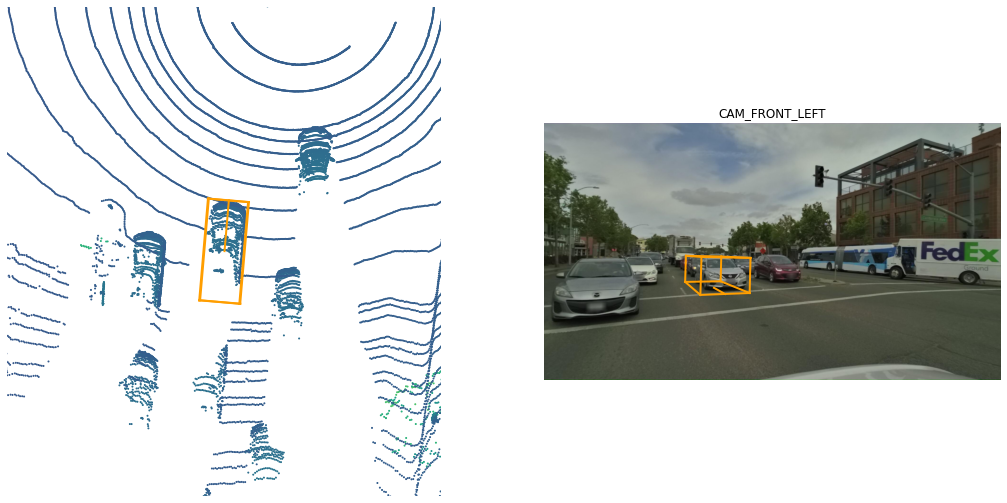

In [ ]:
test = level5data.sample_annotation[0]
translation = test['translation']

print(level5data.get('instance', test['instance_token']))

print(test)
print(translation)
level5data.render_annotation(test['token'])

In [ ]:
import matplotlib.pyplot as plt

import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import os

from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

C:\Users\13015\AppData\Roaming\Python\Python39\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


In [ ]:
os.environ["L5KIT_DATA_FOLDER"] = "E:\\Summer2021Research\\lvl5_pred_sample"

# get config
cfg = load_config_data("E:/Summer2021Research/lvl5_sample/l5kit/examples/visualisation/visualisation_config.yaml")
print(cfg)

print(f'current raster_param:\n')
for k,v in cfg["raster_params"].items():
    print(f"{k}:{v}")

dm = LocalDataManager()
print(os.getcwd())
print(cfg["val_data_loader"]["key"])
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
dataset = AgentDataset(cfg, zarr_dataset, rast)
data = dataset[0]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im)
plt.show()

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
current raster_param:

raster_size:[224, 224]
pixel_size:[0.5, 0.5]
ego_center:[0.25, 0.5]
map_type:py_semantic
satellite_map_key:aerial_map/aerial_map.png
semantic_map_key:semantic_map/semantic_map.pb
dataset_meta_key:meta.json
filter_agents_threshold:0.5
disable_traffic_light_faces:False
set_origin_to_bottom:True
C:\Users\13015
scenes/sample.zarr
+------------

FileNotFoundError: ignored

label: nan, score: nan, xyz: [-7.79, 3.67, 71.67], wlh: [0.87, 1.02, 1.84], rot axis: [0.59, -0.56, 0.59], ang(degrees): 117.30, ang(rad): 2.05, vel: nan, nan, nan, name: pedestrian, token: f207cd2887c851dbf6c5cf4f8b57a8d83ae9af6660e889976227744b2285ded1
[1.714, 4.387, 1.803]
[974.9449183215099, 1639.9428951506682, -23.70817559458233]
{'token': '95535d14ea51dfd566086a90e491d7145ca0160f89b2d2f3ff52bb9e4563c84b', 'num_lidar_pts': -1, 'size': [1.714, 4.387, 1.803], 'sample_token': 'e885595fb2d9fd7028d84f42544aa1b3ec920d4e3164b801a075e681b3169971', 'rotation': [-0.5896956512064944, 0, 0, 0.8076255561509607], 'prev': '03ab1f9956aa027e7182fe54f780b43fd1fde88d2a0f88d9fd0cfabbc5f00d40', 'translation': [974.9449183215099, 1639.9428951506682, -23.70817559458233], 'num_radar_pts': 0, 'attribute_tokens': ['5466ded30df08d7d825412ac907017d6ae00ff19051c63666de3dcc4a535c8cc', 'daf16a3f6499553cc5e1df4a456de5ee46e2e6b06544686d918dfb1ddb088f6f'], 'next': 'bd69fb9fbc61ecd08c7f866491e5102bed42fe1a1fdc21162

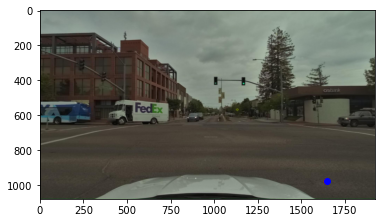

In [ ]:
from lyft_dataset_sdk.lyftdataset import LyftDataset
lvl5_root = 'E:/Summer2021Research/lvl5_sample/'
lvl5_json_path = 'E:/Summer2021Research/lvl5_sample/train_data'
level5data = LyftDataset(data_path=lvl5_root, json_path=lvl5_json_path, verbose=False)

samp_data_token = level5data.sample_data[3]['token']
test = level5data.get_sample_data(samp_data_token)

print(test[1][0])
ann = level5data.get('sample_annotation', test[1][7].token)
crds = ann['translation']
size = ann['size']

print(size)
print(crds)
print(ann)


img = plt.imread(test[0])
plt.imshow(img)
plt.scatter(crds[1], crds[0], s=20, c='red')
plt.scatter(crds[1] + size[1], crds[0] + size[0], c='blue')
plt.show()

In [46]:
print(level5data.ego_pose[0])

{'rotation': [0.9814054059006319, 0.024554359184943367, -0.00675359109067683, -0.19024957745396656], 'translation': [1014.0608584495808, 1686.2475944915398, -24.493329431942247], 'token': '4be92efed994b68dd8626f0cb57c0ea3280bbcfb23e19da3bc1280243ecda116', 'timestamp': 1557858059102331.2}


{'token': 'c9a3c0f86426f5c21518c2ca116b83d5d1b81a4a1a8c54090c997b3ef52b8f4e', 'num_lidar_pts': -1, 'size': [2.097, 5.313, 1.527], 'sample_token': 'f1c84bc22ffa6157bfd83cb5c7a4a75d38fc3800d3e3bd5ae08daf93c966c33c', 'rotation': [0.13945786234471136, 0, 0, 0.9902280063855211], 'prev': '0b277b445065c113ec6240170f6f8bb77331eaf28e9f5b05526ec514b40a1488', 'translation': [1015.4281593633107, 1702.3128236982554, -23.64944355870142], 'num_radar_pts': 0, 'attribute_tokens': ['1ba8c9a8bda54423fa710b0af1441d849ecca8ed7b7f9393ba1794afe4aa6aa2', 'daf16a3f6499553cc5e1df4a456de5ee46e2e6b06544686d918dfb1ddb088f6f'], 'next': '97d99d9aeb70326c429b9dfd33694dfe597024d84520e67ac6fbb791c7f3b706', 'instance_token': 'f8de114c6d97fbc4cb38d6d61f4d85881bdc99e5f6be840a84e3cd5a7b46e67c', 'visibility_token': '', 'category_name': 'car'}
E:\Summer2021Research\lvl5_sample\train_images\host-a101_cam6_1241893247650000006.jpeg
label: nan, score: nan, xyz: [13.73, 13.68, 90.03], wlh: [0.98, 0.90, 2.00], rot axis: [-0.54, 0.

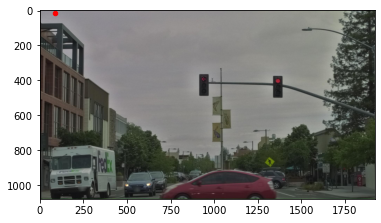

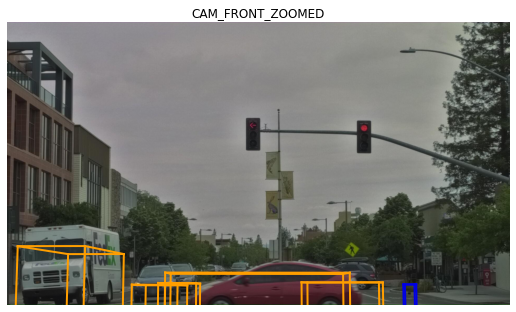

In [ ]:
print(test[0])
print(test[1][0])
print(len(test[1]))
print(test[2])

crds = test[1][0].center
print(crds)

img = plt.imread(test[0])
plt.imshow(img)
plt.scatter(crds[2], crds[1], s=20, c='red')

level5data.render_sample_data(level5data.sample_data[0]['token'])

In [ ]:
from detectron2.data import MetadataCatalog
level5data.list_categories()

Category stats
bus                         n=  126, width= 2.65±0.00, len=18.95±0.00, height= 3.51±0.00, lw_aspect= 7.16±0.00
car                         n= 6062, width= 1.94±0.16, len= 4.72±0.42, height= 1.70±0.20, lw_aspect= 2.44±0.18
other_vehicle               n=   41, width= 2.10±0.00, len= 5.26±0.00, height= 2.55±0.00, lw_aspect= 2.51±0.00
pedestrian                  n=  426, width= 0.69±0.13, len= 0.75±0.15, height= 1.78±0.15, lw_aspect= 1.10±0.21
truck                       n=  407, width= 2.86±0.38, len=10.11±2.77, height= 3.61±0.48, lw_aspect= 3.51±0.72


Nuscenes Main Code

In [ ]:
!mkdir -p /data/sets/nuimages  # Make the directory to store the nuImages dataset in.

!wget https://www.nuscenes.org/data/nuimages-v1.0-mini.tgz  # Download the nuImages mini split.

!tar -xf nuimages-v1.0-mini.tgz -C /data/sets/nuimages  # Uncompress the nuImages mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuImages.

In [ ]:
class SubNuim(torch.utils.data.Dataset):
    """`nuimages

    Args:
    root (string): Root directory where images are downloaded to.
    annFile (string): Path to json annotation file.
    transform (callable, optional): A function/transform that  takes in an PIL image and returns a transformed version. E.g, ``transforms.ToTensor``
    target_transform (callable, optional): A function/transform that takes in the target and transforms it.
    transforms (callable, optional): A function/transform that takes input sample and its target as entry and returns a transformed version.
    """

    def __init__(self, root, annFile, classes, transform=None, target_transform=None, transforms=None):
        # super(CocoDetection, self).__init__(root, transforms, transform, target_transform)
        self.root = root
        self.coco = COCO(annFile) # load entire coco annotation file
        self.transforms = transforms
        self.ids = sorted(self.coco.getImgIds(catIds=self.coco.getCatIds(catNms=classes))) # get list of image ids (indices?) 
        print("number of images in {} = {}".format(classes, len(self.ids)))

    def __getitem__(self, index):
        """
        Args:
            index (int): index

        Returns:
            img, target (tuple): target is the object returned by ``coco.loadAnns``.
        """

        thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19, 22: 20, 23: 21, 24: 22, 25: 23, 27: 24, 28: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39, 46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 52: 46, 53: 47, 54: 48, 55: 49, 56: 50, 57: 51, 58: 52, 59: 53, 60: 54, 61: 55, 62: 56, 63: 57, 64: 58, 65: 59, 67: 60, 70: 61, 72: 62, 73: 63, 74: 64, 75: 65, 76: 66, 77: 67, 78: 68, 79: 69, 80: 70, 81: 71, 82: 72, 84: 73, 85: 74, 86: 75, 87: 76, 88: 77, 89: 78, 90: 79}
        coco = self.coco
        img_id = self.ids[index] # get one image id according to the index
        ann_ids = coco.getAnnIds(imgIds=img_id) # load annotation ids related to that image id
        coco_annotation = coco.loadAnns(ann_ids) # load annotation labels in that image id from annotation ids
      
        path = coco.loadImgs(img_id)[0]['file_name'] # load image annotation related to that image id
        img = Image.open(os.path.join(self.root, path)).convert('RGB') # open the PIL image
        
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []

        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(thing_dataset_id_to_contiguous_id[coco_annotation[i]['category_id']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([img_id])    
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        target["iscrowd"] = iscrowd

        # preprocess image if wanted
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, target

    def __len__(self):
        return len(self.ids)

'E:\\Summer2021Research'

In [ ]:
from nuimages import NuImages

root = 'E:/Summer2021Research/data/sets/nuimages_main'
config_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
nuim = NuImages(dataroot=root, version='v1.0-train', verbose=True, lazy=True)

%cd E:\Summer2021Research\data\sets\nuimages

# includes animals instead of by species and adult/child instead of pedestrian
cats = ['pedestrian', 'car', 'truck']
nuim_samp_cats = [['human.pedestrian.adult', 'human.pedestrian.child', 'human.pedestrian.construction_worker', 'human.pedestrian.personal_mobility', 'human.pedestrian.police_officer', 'human.pedestrian.stroller', 'human.pedestrian.wheelchair'], ['vehicle.car'], ['vehicle.truck']]
nuim_samp_coco_idxs = [0, 2, 7]
nuim_samp_cat_tokens = ['1fa93b757fc74fb197cdd60001ad8abf', 'b1c6de4c57f14a5383d9f963fbdcb5cb', '909f1237d34a49d6bdd27c2fe4581d79', '403fede16c88426885dd73366f16c34a', 'e3c7da112cd9475a9a10d45015424815', '6a5888777ca14867a8aee3fe539b56c4', 'b2d7c6c701254928a9e4d6aac9446d79', 'fd69059b62a3469fbaef25340c0eab7f', '6021b5187b924d64be64a702e5570edf']
nuim_samp_cats_to_coco_ids = {'1fa93b757fc74fb197cdd60001ad8abf' : 0, 'b1c6de4c57f14a5383d9f963fbdcb5cb' : 0, '909f1237d34a49d6bdd27c2fe4581d79' : 0, '403fede16c88426885dd73366f16c34a' : 0, 'e3c7da112cd9475a9a10d45015424815' : 0, '6a5888777ca14867a8aee3fe539b56c4' : 0, 'b2d7c6c701254928a9e4d6aac9446d79' : 0, 'fd69059b62a3469fbaef25340c0eab7f' : 2, '6021b5187b924d64be64a702e5570edf' : 7}

n_epochs = 250
Xi = 10 # [10, 15, 20]
eps = 20 # [1, 5, 10, 20, 30] 
n_imgs = 500
score_thresh = 0.7
iou_thresh = 0.5

img_size = (1600, 900)

model, cfg = get_detector(config_file, score_thresh, data_type='model')

for cat, cat_arr, cls_idx in zip(cats, nuim_samp_cats, nuim_samp_coco_idxs):

  boxes = []
  labels = []

  imgs = []

  # For every annotation of the current category, append token, bbox, etc.
  for fields in nuim.object_ann:

    token = fields['sample_data_token']
    category = nuim.get('category', fields['category_token'])

    if category['name'] in cat_arr:
      if token not in imgs:
        imgs.append(token) # Sample data token for every image with an annotation of a category in cat_arr
        boxes.append([fields['bbox']])
        labels.append([nuim_samp_cats_to_coco_ids[category['token']]])

      else:
        index = imgs.index(token)
        boxes[index].append(fields['bbox'])
        labels[index].append(nuim_samp_cats_to_coco_ids[category['token']])


  imgs = [nuim.get('sample_data', token)['filename'] for token in imgs]
  imgs = [Image.open(os.path.join(root, path)).convert('RGB') for path in imgs]

  boxes = [torch.as_tensor(box, dtype=torch.float32) for box in boxes]
  labels = [torch.as_tensor(label, dtype=torch.int64) for label in labels]

  # Annotation is in dictionary format
  target = [{'boxes' : curr_boxes, 'labels' : curr_labels} for curr_boxes, curr_labels in zip(boxes, labels)]
  dataset = list(zip(imgs, target))
  
  dataset = filter_pos_pred(dataset, model, cls_idx, cfg, 50)
  
  # accepts array of (img matrix, dictionary data with 'box' as [xmin, ymin, xmax, ymax])
  uap, metric_ls = udos(cfg=cfg, model=model, dataset=dataset, n_epochs=n_epochs, Xi=Xi, epsilon=eps, size=img_size, cls=cls_idx)
  metrics = np.array(metric_ls)

  # save list to pickle file
  print(cat)
  file_name = 'cls{}_epochs{}_xi{}_eps{}_imgs{}.pkl'.format(cat, n_epochs, Xi, eps, len(dataset))
  open_file = open(file_name, "wb")
  pickle.dump(metrics, open_file)
  open_file.close()


Loading nuImages tables for version v1.0-train...
Done loading in 0.024 seconds (lazy=True).
E:\Summer2021Research\data\sets\nuimages


The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Loaded 557715 object_ann(s) in 13.256s,
Loaded 25 category(s) in 0.010s,
Loaded 872181 sample_data(s) in 5.933s,


In [ ]:
from nuimages import NuImages

root = 'E:/Summer2021Research/data/sets/nuimages_main'
config_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
nuim = NuImages(dataroot=root, version='v1.0-train', verbose=True, lazy=True)

%cd E:\Summer2021Research\data\sets\nuimages

# includes animals instead of by species and adult/child instead of pedestrian
cats = ['pedestrian', 'car', 'truck']
nuim_samp_cats = [['human.pedestrian.adult', 'human.pedestrian.child', 'human.pedestrian.construction_worker', 'human.pedestrian.personal_mobility', 'human.pedestrian.police_officer', 'human.pedestrian.stroller', 'human.pedestrian.wheelchair'], ['vehicle.car'], ['vehicle.truck']]
nuim_samp_coco_idxs = [0, 2, 7]
nuim_samp_cat_tokens = ['1fa93b757fc74fb197cdd60001ad8abf', 'b1c6de4c57f14a5383d9f963fbdcb5cb', '909f1237d34a49d6bdd27c2fe4581d79', '403fede16c88426885dd73366f16c34a', 'e3c7da112cd9475a9a10d45015424815', '6a5888777ca14867a8aee3fe539b56c4', 'b2d7c6c701254928a9e4d6aac9446d79', 'fd69059b62a3469fbaef25340c0eab7f', '6021b5187b924d64be64a702e5570edf']
nuim_samp_cats_to_coco_ids = {'1fa93b757fc74fb197cdd60001ad8abf' : 0, 'b1c6de4c57f14a5383d9f963fbdcb5cb' : 0, '909f1237d34a49d6bdd27c2fe4581d79' : 0, '403fede16c88426885dd73366f16c34a' : 0, 'e3c7da112cd9475a9a10d45015424815' : 0, '6a5888777ca14867a8aee3fe539b56c4' : 0, 'b2d7c6c701254928a9e4d6aac9446d79' : 0, 'fd69059b62a3469fbaef25340c0eab7f' : 2, '6021b5187b924d64be64a702e5570edf' : 7}


nuim.list_categories()

cats = []
for cat in nuim.category:
  cats.append(cat['name'])

print(cats)


Loading nuImages tables for version v1.0-train...
Done loading in 0.000 seconds (lazy=True).
E:\Summer2021Research\data\sets\nuimages
Loaded 67279 sample(s) in 0.222s,
Loaded 557715 object_ann(s) in 10.319s,
Loaded 73755 surface_ann(s) in 5.348s,
Loaded 25 category(s) in 0.015s,
Loaded 872181 sample_data(s) in 6.818s,

Object_anns Surface_anns Name                     Description                                     
     202809            0 vehicle.car              Vehicle designed primarily for personal use, e.g
     121200            0 human.pedestrian.adult   Adult subcategory.                              
      70112            0 movable_object.barrier   Temporary road barrier placed in the scene in or
      69016            0 movable_object.trafficco All types of traffic cone.                      
      29456            0 vehicle.truck            Vehicles primarily designed to haul cargo includ
      13708            0 vehicle.bicycle          Human or electric powered 2-wheeled

In [ ]:
from nuimages import NuImages

nuim = NuImages(dataroot='E:\Summer2021Research/data/sets/nuimages', version='v1.0-mini', verbose=True, lazy=True)

print(nuim.table_names)
print(nuim.object_ann[0])
print(nuim.sample_data[0])
print(nuim.category[0])
print(nuim.get('category', nuim.object_ann[0]['category_token'])['name'])

#nuim.get_sample_content('f777c493d69948d394fe035fd1d33347')

Loading nuImages tables for version v1.0-mini...
Done loading in 0.001 seconds (lazy=True).
['attribute', 'calibrated_sensor', 'category', 'ego_pose', 'log', 'object_ann', 'sample', 'sample_data', 'sensor', 'surface_ann']
Loaded 506 object_ann(s) in 0.004s,
{'token': '00053e5bedec4ee68f0f24193913ed3a', 'category_token': '6021b5187b924d64be64a702e5570edf', 'bbox': [725, 293, 909, 522], 'mask': {'size': [900, 1600], 'counts': 'bWxcYzA3a2swO0U2SjJOM00yMTJNNExPMk4xMDBPMk4xTzEwM0xlMFtPMTBPMDFPMTBPMDEwTzAxMDBPTTNLNko1SjdKNkU7Qj5CPkE/Qj5CPUk4TzEwME8xTzFPMTAwTzAwMTFPMDAwMDAwMDAwMDBPMTAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDFPMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDFOMTAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDFPMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDFPMDAwMDAwMDFPMDAwMDAwMDAwMDAwMDAwMDEwTzAwMDAwMDAwMDAwMDAwMDAwMU8wMDAwMDAwMDAxTzAwMDAwMU8wMDAwMDAwMDAwMDAwMDAwMU8wMDAxME8wMDFPMDAwMDFPMDAxTzAwMDAxTzFPMU8yTjEwME8xTzFPMU8xTzAwMU9aTl5ZT2tNYGYwYDBWW09BZmgwMU0zSTZDPTBPMU8xMDBPMDAyTjE

In [ ]:
config_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
annFile = 'E:/Summer2021Research/COCO2017/annotations/instances_val2017.json'
root = 'E:/Summer2021Research/COCO2017/val2017'
n_epochs = 250
Xi = 10 # [10, 15, 20]
eps = 20 # [1, 5, 10, 20, 30] 
n_imgs = 50
score_thresh = 0.7
iou_thresh = 0.5

# person=0, bicycle=1, car=2, motorcycle=3, bus=5, truck=7, traffic light=9, stop sign=11
cls_strs = [['person'], ['car'], ['truck'], ['traffic light'], ['stop sign']]
cls_idxs = [0, 2, 7, 9, 11]

cls_str =  cls_strs[0]
coco = SubCocoDetection(root=root, annFile=annFile, classes=cls_str, transforms=get_transform()) # Object Instance

print(coco[0][1]['labels'])

loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
number of images in ['person'] = 2693
tensor([58, 62, 62, 56, 56, 56, 56,  0,  0, 68, 72, 73, 73, 74, 75, 75, 56, 75,
        75, 60])
